Based on https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/ignis/6a_state_tomography.ipynb?fbclid=IwAR1Pf1nH2CBPUWDdsa_xBiYs1kYDu8hwI9dVvr63z7ypmhy2UlR6QpMgJWc, 2-Qubit Conditional State Tomography

# Verifying QEC with Two Extra Qubits on IBM Q computers

## Only post processing

Run all blocks, which includes
- functions
- one simulation to return the basis matrices for tomography circuits (cost some seconds)
- load 4 file from pickle, each represents one experiment for the stabilizer
- post processing...


- Code References
- + [Qiskit Tutorial, 2-Qubit Conditional State Tomography](https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/ignis/6a_state_tomography.ipynb?fbclid=IwAR1Pf1nH2CBPUWDdsa_xBiYs1kYDu8hwI9dVvr63z7ypmhy2UlR6QpMgJWc)
- + [Qiskit source code](https://github.com/Qiskit) `Note` Some functions are modified from built-in methods.

## Initialization

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter
from qiskit.result import Result

import qiskit.ignis.verification.tomography as tom
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.jobstatus import JOB_FINAL_STATES
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Importing other packages
import matplotlib.pyplot as plt
import pickle
import numpy as np
from copy import deepcopy
import time
# Importing measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from itertools import product

# Importing tomography fitter functions
from qiskit.ignis.verification.tomography.fitters import lstsq_fit
from qiskit.ignis.verification.tomography.basis import TomographyBasis
from ast import literal_eval
import itertools as it
from qiskit.ignis.verification.tomography.data import combine_counts, count_keys

#Visualization
%qiskit_job_watcher
%qiskit_progress_bar
from qiskit.tools.parallel import parallel_map
parallel_map(np.sin, np.linspace(0,10,100));

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [3]:
#Getting backends
backend=provider.get_backend('ibmq_16_melbourne')
backend_sim=provider.get_backend('ibmq_qasm_simulator')
backend_sim_local=Aer.get_backend('qasm_simulator')
backend_sv=Aer.get_backend('statevector_simulator')

In [4]:
data_list=[0,1,2,3,4]
syn=[5]
flag=[6]

## State Preparation

In [83]:
"""
StatePreparation(stabilizer: int)
    Return one of the three stabilizers for state preparation in SM of QEC with two extra qubits.
    Variable:
        stabilizer: 0,1, or 2
    Return:
        q: QuantumRegister(7)
        qc: QuantumCircuit(q)

q, qc=StatePreparation(0)
qc.draw()
"""
def StatePreparation(stabilizer=0):#if stabilizer=0: return the ZXIXZ stabilizer, otherwise return the pure state preparation circuit
    if(stabilizer==0):
        q1 = QuantumRegister(7)
        qc = QuantumCircuit(q1)
        
        qc.h(q1[1])
        qc.h(q1[3])
        qc.cx(q1[1],q1[2])
        qc.cx(q1[3],q1[4])
        qc.cx(q1[0],q1[1])
        qc.cx(q1[3],q1[2])
        qc.cx(q1[1],q1[0])
        qc.h(q1[1])
        qc.h(q1[2])
        qc.cx(q1[1],q1[4])
        qc.h(q1[4])

        qc.h(q1[6])
        qc.h(q1[0])
        qc.cx(q1[0],q1[5])
        qc.h(q1[0])
        qc.cx(q1[6],q1[5])
        qc.swap(q1[0],q1[1])
        qc.cx(q1[4],q1[5])
        qc.swap(q1[3],q1[4])
        qc.cx(q1[0],q1[5])
        qc.cx(q1[6],q1[5])
        qc.h(q1[4])
        qc.cx(q1[4],q1[5])
        qc.h(q1[4])
        qc.h(q1[6])
        return q1, qc
    else:
        q1 = QuantumRegister(5)
        qc = QuantumCircuit(q1)
        
        qc.h(q1[1])
        qc.h(q1[3])
        qc.cx(q1[1],q1[2])
        qc.cx(q1[3],q1[4])
        qc.cx(q1[0],q1[1])
        qc.cx(q1[3],q1[2])
        qc.cx(q1[1],q1[0])
        qc.h(q1[1])
        qc.h(q1[2])
        qc.cx(q1[1],q1[4])
        qc.h(q1[4])
        
        for i in range(7):
            qc.i(q1[0])
            qc.barrier()
        return q1, qc

def StatePreparationAll(stabilizer=0):#if stabilizer=-1 or any value that is not 0,1,2, will return a circuit without stabilizer
    q = QuantumRegister(7)
    qc = QuantumCircuit(q)
    #prepare the 5-qubit graph state
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[2])
    qc.h(q[3])
    qc.h(q[4])
    qc.cz(q[0],q[1])
    qc.cz(q[2],q[3])
    qc.cz(q[1],q[2])
    qc.cz(q[3],q[4])
    qc.cz(q[0],q[4])
    #syndrome and flag extraction
    #stabilizer order: from left to right, Fig 2(a), SM of two extra qubits
    if(stabilizer==0):
        #first stabilizer 
        qc.h(q[5])
        qc.cx(q[5],q[0])
        qc.cx(q[5],q[6])
        qc.cz(q[1],q[5])
        qc.cx(q[5],q[6])
        qc.cz(q[4],q[5])
        qc.h(q[5])
    elif(stabilizer==1):
    #second stabilizer
        qc.h(q[5])
        qc.cz(q[0],q[5])
        qc.cx(q[5],q[6])
        qc.cx(q[5],q[1])
        qc.cx(q[5],q[6])
        qc.cz(q[2],q[5])
        qc.h(q[5])
    elif(stabilizer==2):
        #third stabilizer
        qc.h(q[5])
        qc.cx(q[5],q[3])
        qc.cx(q[5],q[6])
        qc.cz(q[2],q[5])
        qc.cx(q[5],q[6])
        qc.cz(q[4],q[5])
        qc.h(q[5])
    #measure syndrome and flag & do state tomography for the data qubits
    qc.barrier()
    #qc.measure(q[5],c[5])
    #qc.measure(q[6],c[6])
    return q, qc

In [6]:
"""
reduced(v: ndarray, sf: str)
    Return the normalized projection result of given state vector onto certain subspace of syndrome&flag outcomes.
    Variables:
        v: ndarray, length 2**7
        sf: '00', '01', '10', or '11', the first bit represents syndrome outcome and the second represents flag.
    Return:
        ndarray (2**5, 1)

    we should have projected the ideal final state to the final state, ...
    'reduced(v,sf)' returns the projected states based on 'sf'.
    At the moment, for the (ideal) simulation result, 'sf' can only be '00'
    and the func simply returns the first 32 elements of v.
"""
def reduced(v, sf):
    s=int(sf[0])
    f=int(sf[1])
    out=s*2+f
    res=[]
    for i in range(v.shape[0]):
        if((i>>5)==out):#((i%4)==out):#
            res.append(v[i])
    res=np.array(res)
    res=res/np.sqrt(np.sum(np.power(np.abs(res),2)))
    return np.array(res)

## Pre-processing

### Error Mitigation

In [7]:
def msmtErrorMitFilter(backend, measured_qubit_list):
    # backend is the backend from which we obtain measurement error rates
    #measured_qubit_list contains
    qr = QuantumRegister(len(measured_qubit_list))
    qubit_list = range(len(measured_qubit_list))
    
    # Create the measurement calibration circuits
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
    
    # Create a noise model with the qubits being measured
    noise_model = noise.NoiseModel()
    back_prop = backend.properties()
    for qi in range(len(measured_qubit_list)):
        m0_p1 = back_prop.qubit_property(qi,name='prob_meas0_prep1')[0]
        m1_p0 = back_prop.qubit_property(qi,name='prob_meas1_prep0')[0]
        read_err = noise.errors.readout_error.ReadoutError([[1-m1_p0, m1_p0],[m0_p1,1-m0_p1]])
        noise_model.add_readout_error(read_err, [qi])
    
    # Execute the calibration circuits
    job = execute(meas_calibs, backend=backend_sim_local, shots=1000, noise_model=noise_model)
    cal_results = job.result()
    
    # Calculate the calibration matrix with the noise model
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')

    # Get the filter object
    meas_filter = meas_fitter.filter
    
    return meas_filter

# Please check msmtErrorMitOnTom().

Changes: 
    - `old_counts` -> list of results.get_counts(data_idx)
    - `mitigated_results` is `results` instead of a deepcopy of `results`
    - For results obtained from melbourne, will return a dict like {"(X,X,X,X,X)": {'00 10101':12.2343234.... instead

In [8]:
def msmtErrorMitOnTom(results, meas_filter, backend_type='simulation', basis_list=None):
    
#     print(results)
    #mitigated_results = deepcopy(results)
    old_counts=[]
    for data_idx in range(243):#, _ in enumerate(results.results):
        old_counts.append(results.get_counts(data_idx))
    if(backend_type=='simulation'):
        mitigated_results = results
    else:
        mitigated_results = {}
    for data_idx in range(243):#results.results):
        new_counts = {}
        # removes key structure
        for reg_key in old_counts[data_idx]:
            reg_bits = reg_key.split(' ')
            if(len(reg_bits)>1):
                reg_bits = reg_bits[0]+reg_bits[1]
                new_counts[reg_bits]=old_counts[data_idx][reg_key]
            else:
                new_counts[reg_key]=old_counts[data_idx][reg_key]
                        
        # applies measurement filter
#         print(new_counts)
        new_counts1 = meas_filter.apply(new_counts)
#        print(type(new_counts1))
#        print(new_counts1)
        
#         #replaces key structure
        new_counts2 = {}
        for reg_key in new_counts1:
            #print(type(reg_key))
            reg_bits = []
            if(len(reg_key)==7):
                reg_bits.append(reg_key[0:2])
                reg_bits.append(reg_key[2:7])
                reg = reg_bits[0] + " " + reg_bits[1]
            else:
                reg=reg_key
            new_counts2[reg]=new_counts1[reg_key]
        #print(new_counts2)
        if(backend_type=='simulation'):
            mitigated_results.results[data_idx].data.counts = \
                mitigated_results.results[data_idx]. \
                data.counts.from_dict(new_counts1)
        elif(backend_type=='experiment'):
            mitigated_results[basis_list[data_idx]] = \
                new_counts2
#         new_result.results[resultidx].data.counts = \
#                     new_result.results[resultidx]. \
#                     data.counts.from_dict(new_counts)
        
#     print(mitigated_results)
    return mitigated_results

In [9]:
def sort_list(list1, list2): 
    # sorts list 1 based on the sort indices of list 2
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
      
    return z 

In [10]:
def extractMsmtQubits(circuit):

    # 'circuit' is the circuit for which we extract the list of measurement qubits
    # This is some messy code. Not sure if we necessarily have to parse the qasm file of a circuit to find the qubits being measured
    # Doesn't work too well when there are two classical registers. I've written up a fix but not happy with it.
    qasm_obj = circuit.qasm()
    t = qasm_obj.find("measure")
    qasm_obj = qasm_obj[t:-1]
    qasm_obj = qasm_obj.split(' ')
    listmsmt = []
    listclass = []
    for _ in qasm_obj:
        if 'q' in _:
            number = []
            for j in range(len(_)):
                if _[j] =='[':
                    temp1 = _[j+1:j+3].strip(']')
            listmsmt.append(int(temp1))
    for _ in qasm_obj:
        if 'c' in _:
            number = []
            for j in range(len(_)):
                if _[j] =='[':
                    temp1 = _[j+1:j+3].strip(']')
            if temp1 == '0' and len(listclass) > 4:
                temp1 = '5'
            if temp1 == '1' and len(listclass) > 4:
                temp1 = '6'
            listclass.append(int(temp1))
    listmsmt = sort_list(listmsmt, listclass)
#     print(listmsmt)
#     print(listclass)
    return listmsmt

### Executing the Circuits

Circuit | Description 
---| ---
qc0 | As shown in [6], state prepartion + stabilizer, no measurement
qc1 | add measurements on syndrome and flag qubits
qctom | add measurements on syndrome and flag qubits, then do state tomography on data qubits, used for tomography by both simulation and experiment
qctom_no_anc | qctom without measurement, used for 'tom.stateTomographyFitter'


In [11]:
"""
updated: specified for low-depth circuits
!!OLD!!executeStatePreparation(stabilizer: int, backend_type: str, mitigation: boolean)
Variables:
    stabilizer: 0, 1 or 2, determine which stabilizer to be chosen
    backend_type: 'simulation', use qasm to simulate the circuit or 'experiment', use melbourne to run real quantum experiement
    mitigation: True, use error mitigation to preprocess the results; False: no error mitigation.
    
Return:
    backend_type=='simulation':
        psi_qc, qctom, qctom_no_anc, results_sim
"""
def executeStatePreparation(stabilizer=0, initial_layout=None, backend_type='simulation', mitigation=True):
    #state vector
    q0, qc0=StatePreparation(stabilizer)
    qc0.draw()
    if(stabilizer==-1):#just state preparation
        qctom = tom.state_tomography_circuits(qc0, data_list, meas_labels='Pauli', meas_basis='Pauli')
        if(backend_type=='simulation'):
            print('TBD')
            return None
        if(backend_type=='experiment'):
            job = execute(qc0, backend_sv)
            psi_qc = job.result().get_statevector(qc0)

            max_job_count = 5
            max_exp_per_job = 54
            qctom_job = transpile(qctom, backend=backend, optimization_level=0, initial_layout=initial_layout)
            job_manager = IBMQJobManager()
            start_time = time.time()

            job_set_foo = job_manager.run(qctom_job, 
                                          backend=backend, name='qctom', shots=8192, max_experiments_per_job=54)
            job_status = job_set_foo.statuses()
            while job_status[max_job_count-1] not in JOB_FINAL_STATES:
                print(f'Status @ {time.time()-start_time:0.0f} s: {job_status[max_job_count-1]},'
                   f' ')
                time.sleep(10)
                job_status = job_set_foo.statuses()

            results_real = job_set_foo.results()   

            # Create an error mitigation filter
            if(mitigation==True):
                measured_qubit_list = extractMsmtQubits(qctom[-1]) # assuming all the tomo circuits are identical except for basis changes
                filt = msmtErrorMitFilter(backend, measured_qubit_list)
                # Perform error mitigation on all the results
                results_real_MM = msmtErrorMitOnTom(results_real, filt, backend_type='experiment', basis_list=basis)
                results_real=results_real_MM
                #results_real will be a dict
            return (psi_qc, qctom_job, qctom, (results_real, job_set_foo))
            
    if(stabilizer==0):#ZXIXZ
        qc1=deepcopy(qc0)
        ca1 = ClassicalRegister(2)
        qc1.add_register(ca1)
        qc1.measure([q0[5],q0[6]],[ca1[0],ca1[1]])
        job = execute(qc1, backend_sv)
        psi_qc = job.result().get_statevector(qc1)

        #qasm simulation
        qctom = tom.state_tomography_circuits(qc0, data_list, meas_labels='Pauli', meas_basis='Pauli')
        qctom_no_anc = deepcopy(qctom)
        for qc in qctom:
            ca = ClassicalRegister(2)
            qc.add_register(ca)
            qc.measure([q0[5],q0[6]],[ca[0],ca[1]])

        # Create a noise model with the qubits being measured ------
        # ------used for testing measurement error mitigation on the simulator
        if(backend_type=='simulation'):
            noise_model = noise.NoiseModel()
            back_prop = backend.properties()
            measured_qubit_list = extractMsmtQubits(qctom[-1])
            for qi in range(len(measured_qubit_list)):
                m0_p1 = back_prop.qubit_property(qi,name='prob_meas0_prep1')[0]
                m1_p0 = back_prop.qubit_property(qi,name='prob_meas1_prep0')[0]
                read_err = noise.errors.readout_error.ReadoutError([[1-m1_p0, m1_p0],[m0_p1,1-m0_p1]])
                noise_model.add_readout_error(read_err, [qi])

            job = execute(qctom, backend=backend_sim, optimization_level=0, shots=8192, noise_model=noise_model)
            results_sim=job.result()
            # Create an error mitigation filter ------
            # ------used for testing measurement error mitigation on the simulator
            if(mitigation==True):
                measured_qubit_list = extractMsmtQubits(qctom[-1]) # assuming all the tomo circuits are identical except for basis changes
                #Print(measured_qubit_list)
                filt = msmtErrorMitFilter(backend, measured_qubit_list)
                # Perform error mitigation on all the results
                results_sim_MM = msmtErrorMitOnTom(results_sim, filt)
                results_sim = results_sim_MM

            return (psi_qc, qctom, qctom_no_anc, results_sim)#, tomo_qc_sim)

        if(backend_type=='experiment'):
            max_job_count = 5
            max_exp_per_job = 54

            qctom = transpile(qctom, backend=backend, optimization_level=0, initial_layout=initial_layout)

            #results_real=[]
            #tomo_qc_real=[]

            job_manager = IBMQJobManager()
            start_time = time.time()
            #for qc in qctom:
            job_set_foo = job_manager.run(qctom, backend=backend, name='qctom', shots=8192, max_experiments_per_job=54)
            job_status = job_set_foo.statuses()
            while job_status[max_job_count-1] not in JOB_FINAL_STATES:
                print(f'Status @ {time.time()-start_time:0.0f} s: {job_status[max_job_count-1]},'
                   f' ')
                time.sleep(10)
                job_status = job_set_foo.statuses()

            results_real = job_set_foo.results()   

            # Create an error mitigation filter
            if(mitigation==True):
                measured_qubit_list = extractMsmtQubits(qctom[-1]) # assuming all the tomo circuits are identical except for basis changes
                filt = msmtErrorMitFilter(backend, measured_qubit_list)
                # Perform error mitigation on all the results
                results_real_MM = msmtErrorMitOnTom(results_real, filt, backend_type='experiment', basis_list=basis)
                results_real=results_real_MM
                #results_real will be a dict
            return (psi_qc, qctom, qctom_no_anc, (results_real, job_set_foo))

        return (psi_qc, qctom, qctom_no_anc, None)

In [12]:
sim_dict={}
for i in range(1):
    data = executeStatePreparation(i, mitigation=True)
    sim_dict[i]=data
    pickle.dump(data, open("0510 simulation 0 stabilizer=%d"%i, "wb"))


In [13]:
psi_qc_sim, qctom_sim, qctom_no_anc_sim, res_sim = sim_dict[0]

In [14]:
basis=[]
for i in range(243):
    basis.append(res_sim.results[i].header.name)

### Pre-processing

In [15]:
def bin_format(integer, length):
    return f'{integer:0>{length}b}'
              
def measurement_matrix(label, outcome):
    if(label=='X'):
        if(outcome=='0' or outcome==0):
            return np.array([[0.5+0.j, 0.5+0.j], [0.5+0.j, 0.5+0.j]], dtype=complex)
        elif(outcome=='1' or outcome==1):
            return np.array([[ 0.5+0.j, -0.5+0.j], [-0.5+0.j,  0.5+0.j]], dtype=complex)
    elif(label=='Y'):
        if(outcome=='0' or outcome==0):
            return np.array([[ 0.5+0.j, -0. -0.5j], [ 0. +0.5j,  0.5+0.j ]], dtype=complex)
        elif(outcome=='1' or outcome==1):
            return np.array([[ 0.5+0.j, 0. +0.5j], [-0. -0.5j,  0.5+0.j ]], dtype=complex)
    elif(label=='Z'):
        if(outcome=='0' or outcome==0):
            return np.array([[1.+0.j, 0.+0.j], [0.+0.j, 0.+0.j]], dtype=complex)
        elif(outcome=='1' or outcome==1):
            return np.array([[0.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]], dtype=complex)

def _binomial_weights(counts, beta):
    shots=np.sum(counts)
    #beta=0.5
    outcomes_num = len(counts)
    # Compute hedged frequencies which are shifted to never be 0 or 1.
    freqs_hedged = (counts+beta)/(shots+outcomes_num*beta)
    # Return gaussian weights for 2-outcome measurements.
    return np.sqrt(shots/(freqs_hedged*(1-freqs_hedged)))

def _measurement_ops(label):#, meas_matrix_fn):
    #print(label)
    num_qubits=len(label)
    #print(num_qubits)
    meas_ops=[]
    for outcomes in sorted(it.product((0,1), repeat=num_qubits)):# (0,0,0,0,0)...(1,1,1,1,1)
        op=np.eye(1, dtype=complex)
        for m, outcome in zip(reversed(label), outcomes):#'X', 0...
            op=np.kron(op, measurement_matrix(m, outcome))
            #op=np.kron(op, meas_matrix_fn(m, outcome))
        meas_ops.append(op)
    return meas_ops

def _basis_operator_matrix(basis):
    num_ops=len(basis)
    nrows, ncols = basis[0].shape
    size = nrows * ncols
    ret = np.zeros((num_ops, size), dtype=complex)
    for j, b in enumerate(basis):
        ret[j] = np.array(b).reshape((1, size), order='F').conj()
    return ret

def preprocessing(result, basis_list=None, size=7):#result could be res_sim_M
    data={}
    #print(type(result))
    if(basis_list==None):
        res=result.results
        for i in range(243):
            data[res[i].header.name]=result.get_counts(i) 
    else:
        if(type(result)==dict):
            data = result
        else:
            for i in range(243):
                data[basis_list[i]]=result.get_counts(i)
    data_fit={}
    for basis in data.keys():
        tup=literal_eval(basis)
        counts=data[basis]
        if(data_fit.get(tup, 0)!=0):
            data_fit[tup]=combine_counts(data_fit[tup], counts)
        else:
            data_fit[tup]=counts
    return data_fit
#return: data_sim_fit

"""
fitter_data(data)
    Modified from [TomographyFitter's built-in method _fitter_data()](https://github.com/Qiskit/qiskit-ignis/blob/dd2c9265603329662f67a59a0e47744685b430d0/qiskit/ignis/verification/tomography/fitters/base_fitter.py)
    Variable: 
    Return:
        A tuple(fit_list, basis_blocks, weights)
        fit_list: list of int(no error mitigation) or float(with error mitigation) (length=243*32)
        basis_blocks: list of (32, 1024) ndarrays, length=243
        weights: list of float, length=243*32
"""
def fitter_data(data, sf='00', size=7):#data_sim_fit
    #self._meas_basis!=None
    #measurement=meas_basis.measurement_matrix
    #self._prep_basis==None
    preparation=None
    fit_list=[]
    basis_blocks=[]
    weights=[]#standard_weights=True
    wts=0
    cts=0
    #Generate counts keys for converting to np array - is_qpt=false
    ctkeys=count_keys(5) #len(label), 5 for [[5,1,3]]

    for label, cts in data.items():
        # Convert counts dict to numpy array#only results with 00 outcomes are kept
        if(size==7):
            cts=np.array([cts.get(sf+' '+key, 0) for key in ctkeys])#'00 '+key, 0) for key in ctkeys])
        else:
            cts=np.array([cts.get(key, 0) for key in ctkeys])
        # Get probabilities
        shots=np.sum(cts)
        probs=np.array(cts)/shots
        fit_list+=list(probs)
        # Compute binomial weights - standard_weights is True
        wts=_binomial_weights(cts, 0.5)
        weights+=list(wts)
              
        # Get reconstruction basis operators - TBD
        prep_label=None
        meas_label=label
        #print(meas_label)
        prep_op=np.eye(1, dtype=complex)
        meas_ops=_measurement_ops(meas_label)#, measurement)

        block=_basis_operator_matrix([np.kron(prep_op.T, mop) for mop in meas_ops])
        basis_blocks.append(block)

    basis_blocks=np.vstack(basis_blocks)
    return fit_list, basis_blocks, weights

## Fidelity

In [16]:
"""
fidelity(data)
Variable
    data: A tuple (psi_qc, qctom, qctom_no_anc, res) for both simulation and experiment, should be 'dict[i](i=0, 1 or 2)' if the cells above are used.
    sf: syndrom & flag outcomes, '00', '01', '10', or '11'
Return:
    fidelity: a float number
"""
def fidelity(data, sf='00', backend_type='simulation', basis_list=None, size=7, returnReconstruction=False):
    psi_qc, qctom, qctom_no_anc, res= data
    if(backend_type=='simulation'):
        data_fit=preprocessing(res)
        fit_list, basis_blocks, weights=fitter_data(data_fit, sf=sf, size=size)
        #lstsq, result=(32, 32) ndarray
        result=lstsq_fit.lstsq_fit(fit_list, basis_blocks, weights=weights, psd=True, trace=1)
        if(returnReconstruction):
            return result
        return state_fidelity(result, reduced(psi_qc,sf))
    if(backend_type=='experiment'):
        data_fit=preprocessing(res, basis_list=basis_list, size=size)
        #print(data_fit)
        fit_list, basis_blocks, weights=fitter_data(data_fit, sf=sf, size=size)
        #lstsq, result=(32, 32) ndarray
        result=lstsq_fit.lstsq_fit(fit_list, basis_blocks, weights=weights, psd=True, trace=1)
        if(returnReconstruction):
            return result
        return state_fidelity(result, reduced(psi_qc,sf))

In [30]:
def gate_time(back_dict):
    gate_dict={}
    for gate in back_dict['gates']:
        #print(gate)
        for param in gate['parameters']:
            #print(param)
            if(param['name']=='gate_length'):
                length=param['value']
                gate_dict[(gate['gate'], tuple(gate['qubits']))]=length
                break
    return gate_dict

0510 no mitigation round=1 circuit=2.pickle
0.027457589612389054
7583.999999999999


<Figure size 432x288 with 0 Axes>

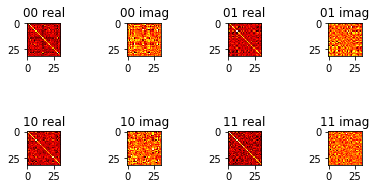

<Figure size 432x288 with 0 Axes>

In [84]:
grid = plt.GridSpec(2, 4, wspace=2, hspace=0)
cnt=1
for Round in [1]:#,2,3,4]:
    filename="0510 no mitigation round=%d circuit=2.pickle" % (Round)
    print(filename)
    _, data_new, back_prop = pickle.load(open(filename, "rb"))
    print(fidelity(data_new, sf='00', backend_type='experiment', basis_list=basis,size=7))
    psi_qc_new, qctom_new, qctom_no_anc_new, res_new=data_new
    gate_dict=gate_time(back_prop.to_dict())
    qctom_new_instruction=qctom_new[-1].to_instruction()
    wire_time = np.zeros(15)
    for i in range(len(qctom_new_instruction.definition)-5):#-5: omit the last five measurement operations
        gate, qubit, _=qctom_new_instruction.definition[i]
        if(gate.name=='measure' or gate.name=='barrier'):
            continue
        index=[qubit[j].index for j in range(len(qubit))]
        #print(gate.name,index,gate_dict[(gate.name, tuple(index))])
        max_tmp=0
        for ind in index:
            if(wire_time[ind]>max_tmp):
                max_tmp=wire_time[ind]
        for ind in index:
            wire_time[ind]=max_tmp+gate_dict[(gate.name, tuple(index))]
    print(np.max(wire_time))
    #print(wire_time)
    for cnt, sf in enumerate(['00','01','10','11']):
        #print(cnt, sf)
        reconstructed_dm=fidelity(data_new, sf=sf, backend_type='experiment', basis_list=basis,size=7, returnReconstruction=True)
        plt.subplot(grid[(cnt*2+0)//4,(cnt*2+0)%4]).imshow(np.real(reconstructed_dm), cmap='hot', interpolation='nearest')
        plt.subplot(grid[(cnt*2+0)//4,(cnt*2+0)%4]).set_title(sf+' real')
        plt.subplot(grid[(cnt*2+1)//4,(cnt*2+1)%4]).imshow(np.imag(reconstructed_dm), cmap='hot', interpolation='nearest')
        plt.subplot(grid[(cnt*2+1)//4,(cnt*2+1)%4]).set_title(sf+' imag')

    
plt.figure()

Time for one stabilizer: $5056\mu s$

In [44]:
sil=[
    (-1, (1,2,3,11,12)),
    (-1, (11,12,13,1,2)),
    (0,  (11,12,13,1,2,3,4)),
    (-2, (1,2,3,11,12)),
    (-2, (11,12,13,1,2)),
]

In [43]:
#Correctly Extended (81 Identity gates) Circuit for just state preparation
for Rc in [(0,0), (0,1), (1,0), (1,1)]:
    Round, circuit=Rc
    print('Round=', Round, 'circuit=', circuit, 'initial_layout=', sil[circuit][1])
    _, data, back_prop=pickle.load(open("0511 no mitigation rightExtendedCircuit(81 id) round=%d circuit=%d.pickle" % (Round, circuit),"rb"))
    print(fidelity(data, sf='00', backend_type='experiment', basis_list=basis,size=5))
    psi_qc_pure, qctom_job_pure, qctom_pure, res_pure = data

    gate_dict=gate_time(back_prop.to_dict())
    qctom_instruction=qctom_job_pure[-1].to_instruction()
    wire_time = np.zeros(15)
    for i in range(len(qctom_instruction.definition)-5):#-5: omit the last five measurement operations
        gate, qubit, _=qctom_instruction.definition[i]
        if(gate.name=='measure' or gate.name=='barrier'):
            continue
        index=[qubit[j].index for j in range(len(qubit))]
        #print(gate.name,index,gate_dict[(gate.name, tuple(index))])
        max_tmp=0
        for ind in index:
            if(wire_time[ind]>max_tmp):
                max_tmp=wire_time[ind]
        for ind in index:
            wire_time[ind]=max_tmp+gate_dict[(gate.name, tuple(index))]
    print('Circuit time:', np.max(wire_time))
    #print(wire_time)
    

Round= 0 circuit= 0 initial_layout= (1, 2, 3, 11, 12)
0.04361347368412695
Circuit time: 6126.222222222215
Round= 0 circuit= 1 initial_layout= (11, 12, 13, 1, 2)
0.05515835190437418
Circuit time: 6538.666666666658
Round= 1 circuit= 0 initial_layout= (1, 2, 3, 11, 12)
0.04229279175228915
Circuit time: 6126.222222222215
Round= 1 circuit= 1 initial_layout= (11, 12, 13, 1, 2)
0.05519039807341851
Circuit time: 6538.666666666658


Round= 0 circuit= 0 initial_layout= (1, 2, 3, 11, 12)
Round= 0 circuit= 1 initial_layout= (11, 12, 13, 1, 2)


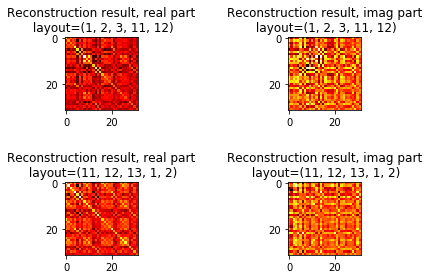

In [62]:
#Correctly Extended (81 Identity gates) Circuit for just state preparation
grid = plt.GridSpec(2, 2, wspace=1, hspace=1)
cnt=0
for Rc in [(0,0), (0,1)]:#, (1,0), (1,1)]:
    Round, circuit=Rc
    print('Round=', Round, 'circuit=', circuit, 'initial_layout=', sil[circuit][1])
    _, data, back_prop=pickle.load(open("0511 no mitigation rightExtendedCircuit(81 id) round=%d circuit=%d.pickle" % (Round, circuit),"rb"))
    reconstructed_dm=fidelity(data, backend_type='experiment', basis_list=basis,size=5, returnReconstruction=True)
    plt.subplot(grid[circuit,0]).imshow(np.real(reconstructed_dm), cmap='hot', interpolation='nearest')
    plt.subplot(grid[circuit,0]).set_title('Reconstruction result, real part\n layout=%s' % (str(sil[circuit][1])))
    plt.subplot(grid[circuit,1]).imshow(np.imag(reconstructed_dm), cmap='hot', interpolation='nearest')
    plt.subplot(grid[circuit,1]).set_title('Reconstruction result, imag part\n layout=%s' % (str(sil[circuit][1])))
    cnt+=1
    psi_qc_pure, qctom_job_pure, qctom_pure, res_pure = data
plt.show()

In [82]:
for Rc in [(0,3), (0,4)]:#(1,3), (1,4)
    Round, circuit=Rc
    print('Round=', Round, 'circuit=', circuit, 'initial_layout=', sil[circuit][1])
    _, data, back_prop=pickle.load(open("0511 with mitigation no extension round=%d circuit=%d.pickle" % (Round, circuit),"rb"))
    print(fidelity(data, sf='00', backend_type='experiment', basis_list=basis,size=5))
    psi_qc_pure, qctom_job_pure, qctom_pure, res_pure = data

    gate_dict=gate_time(back_prop.to_dict())
    qctom_instruction=qctom_job_pure[-1].to_instruction()
    wire_time = np.zeros(15)
    for i in range(len(qctom_instruction.definition)-5):#-5: omit the last five measurement operations
        gate, qubit, _=qctom_instruction.definition[i]
        if(gate.name=='measure' or gate.name=='barrier'):
            continue
        index=[qubit[j].index for j in range(len(qubit))]
        #print(gate.name,index,gate_dict[(gate.name, tuple(index))])
        max_tmp=0
        for ind in index:
            if(wire_time[ind]>max_tmp):
                max_tmp=wire_time[ind]
        for ind in index:
            wire_time[ind]=max_tmp+gate_dict[(gate.name, tuple(index))]
    print('Circuit time:', np.max(wire_time))
    #print(wire_time)
    

Round= 0 circuit= 3 initial_layout= (1, 2, 3, 11, 12)
0.4375598736931011
Circuit time: 2904.8888888888887
Round= 0 circuit= 4 initial_layout= (11, 12, 13, 1, 2)
0.3853108986970224
Circuit time: 3264.0


In [18]:
reconstruction4_01=fidelity(data_new, sf='01', backend_type='experiment', basis_list=basis,size=7, returnReconstruction=True)
reconstruction4_01=reconstruction4_01/reconstruction4_01[0][0]

In [19]:
reconstruction4_10=fidelity(data_new, sf='10', backend_type='experiment', basis_list=basis,size=7, returnReconstruction=True)
reconstruction4_10=reconstruction4_10/reconstruction4_10[0][0]

In [45]:
reconstruction4_00=fidelity(data_new, sf='00', backend_type='experiment', basis_list=basis,size=7, returnReconstruction=True)
#reconstruction4_00=reconstruction4_00/reconstruction4_00[0][0]

In [21]:
psi_qc_1, qctom_1, qctom_no_anc_1, res_1= data_new
psi_reduced=reduced(psi_qc_1, '00').reshape(32,1)
ideal_dm=np.dot(psi_reduced, psi_reduced.conj().T)

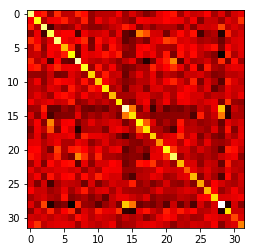

In [22]:
plt.imshow(np.real(reconstruction4_00), cmap='hot', interpolation='nearest')

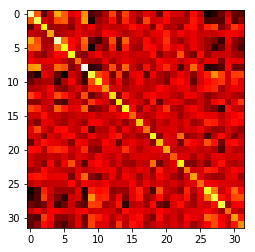

In [23]:
plt.imshow(np.real(reconstruction4_01), cmap='hot', interpolation='nearest')

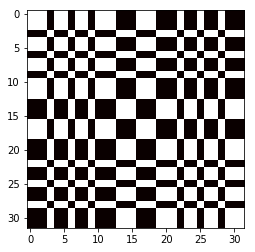

In [80]:
plt.imshow(np.real(ideal_dm), cmap='hot', interpolation='nearest')

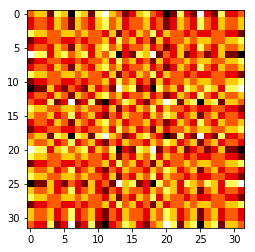

In [79]:
plt.imshow(np.imag(ideal_dm), cmap='hot', interpolation='nearest')

## Try to do better post-processing - averaged one-qubit error could behave like partial depolarizing channel

In [25]:
phi_134={}
phi_134['00']=np.array([ 1, 1, 1, 1, 1,-1, 1,-1]).reshape(8,1)
phi_134['01']=np.array([ 1,-1,-1, 1, 1, 1,-1,-1]).reshape(8,1)
phi_134['10']=np.array([ 1, 1,-1,-1,-1, 1, 1,-1]).reshape(8,1)
phi_134['11']=np.array([ 1,-1, 1,-1,-1,-1,-1,-1]).reshape(8,1)

In [26]:
for i in range(32):
    bit=bin_format(i,5)
    b25=bit[1]+bit[0]